<a href="https://colab.research.google.com/github/dneal3/MachineLearning/blob/master/HandwrittenRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Setting up Imports and Important Variables

In [0]:
import torch
import torchvision

In [0]:
n_epochs = 20
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

from google.colab import drive
drive.mount('/content/drive') # files in Drive are accessable from /content/drive/my Drive/...
# Unfortunately This code is not usuable by anyone other than me as I am not providing the dataset because it is hosted on my own google drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Loading in the MNIST data set
> We can use this data in order to test if our models work well on this data set, and then use the data set we have created in order to create the model we are actually seeking

> As a disclaimer much of this code was not created by me, but was given in CIS 472 Programming Assignment 2. Some may also be taken from some of my references, if taken from a reference I will cite it in that code block 


In [0]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True, 
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 8795242.87it/s]                            


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 138791.90it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2313800.98it/s]                            
0it [00:00, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51627.01it/s]            


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
train_data_root = '/content/drive/My Drive/Colab Notebooks/training-images'
valid_data_root = '/content/drive/My Drive/Colab Notebooks/valid-images'
train_transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1042,), (0.2175,))])
valid_transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.0937,), (0.2008,))])

train_dataset = torchvision.datasets.ImageFolder(root=train_data_root, transform=train_transform)
valid_dataset = torchvision.datasets.ImageFolder(root=valid_data_root, transform=valid_transform)

my_data_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
my_data_valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=20, shuffle=True) # this will essentially be serving ad the validation set

In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

my_examples = enumerate(my_data_valid_loader)
batch_idx2, (my_example_data, my_example_targets) = next(my_examples)


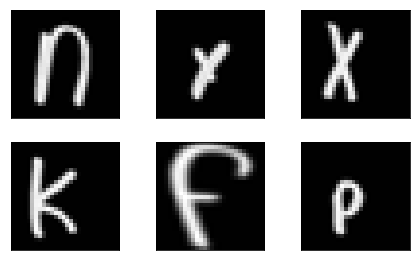

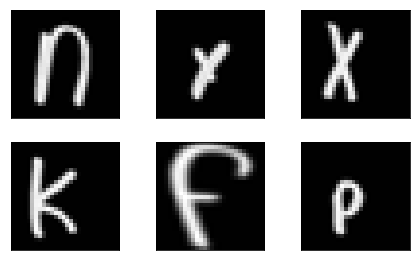

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(my_example_data[i][0], cmap='gray', interpolation='none')
  #plt.title("Ground Truth: {}".format(my_example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Creating the Models

> I plan on using multiple models in order to add another layer of analysis to this project, and I will be declaring them in this section. Each model will be sufficiently different and there will be a short description of what each does, and how they are different from those declared above. They will also be thouroughly described in the Experiment portion of the description at the top of this notebook. 

> One of these Models is  a multi layered perceptron. Commonly during my research I have seen the comparison of of convolutional neural nets to that of a multi layered perceptron, so I'll be using a MLP with a hidden layer containing 128 relu neurons.

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
# This model from https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

# All of these models are described in my Final Paper, refer to that for understanding and intuition on the models.

class TLConvNet(nn.Module):
    def __init__(self):
        super(TLConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(1024, 750)
        self.fc2 = nn.Linear(750, 26) 
    
    def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = out.reshape(out.size(0), -1)
      out = self.drop_out(out)
      out = self.fc1(out)
      out = self.fc2(out)
      return F.log_softmax(out)

In [0]:
class OLConvNet(nn.Module):
    def __init__(self):
        super(OLConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(4608, 750) # will need to change
        self.fc2 = nn.Linear(750, 26) # change to 26 because alphabet
    
    def forward(self, x):
      out = self.layer1(x)
      out = out.reshape(out.size(0), -1)
      out = self.drop_out(out)
      out = self.fc1(out)
      out = self.fc2(out)
      return F.log_softmax(out)

In [0]:
# Feed-Foward Network that has 1 hidden layer with 128 relu acticated neurons in it, made by me for the extra credit assignment.
class FFN128R(nn.Module): 
  def __init__(self):
    super (FFN128R, self).__init__()
    self.fc1 = nn.Linear(784, 128)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(128, 26) # change to 26
    
  
  def forward(self, x):
    out = x.reshape(x.size(0), -1)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    return F.log_softmax(out)

# Training and Testing the Models

> The training and testing functions I used for these are from the extra credit assignment that we did in class, The framework was already done, and it's tunable for my needs, so I figured I may as well use it to evaluate and train my models.

In [0]:
# initialize the network and optimize it using adam

network = FFN128R()


optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [0]:
# utility containers to record how training process goes, used for later visulaztions
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

my_test_counter = [i*len(my_data_train_loader.dataset) for i in range(n_epochs + 1)]
my_train_losses = []
my_train_counter = []
my_test_losses = []
my_valid_accuracy_x = [i for i in range(n_epochs+1)]
my_valid_accuracy_y = []

def my_train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(my_data_train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(my_data_train_loader.dataset),
        100. * batch_idx / len(my_data_train_loader), loss.item()))
      my_train_losses.append(loss.item())
      my_train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(my_data_train_loader.dataset)))
      

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      

In [0]:
def my_test(): # this is testing the model against the validation set not an actual test set, as I am short of time it will have to suffice.
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in my_data_valid_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(my_data_valid_loader.dataset)
  my_test_losses.append(test_loss)
  my_valid_accuracy_y.append(100. * int(correct) / len(my_data_valid_loader.dataset))
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(my_data_valid_loader.dataset),
    100. * correct / len(my_data_valid_loader.dataset)))

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  my_valid_accuracy_y.append(100. * int(correct) / len(test_loader.dataset))
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [0]:
my_test()
for epoch in range(1, n_epochs+1):
  my_train(epoch)
  my_test()

for i in range(len(my_valid_accuracy_y)):
  my_valid_accuracy_y[i] = round(my_valid_accuracy_y[i], 1)
print(my_valid_accuracy_y)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 3.2978, Accuracy: 10/247 (4%)

Train Epoch: 1 [0/1082 (0%)]	Loss: 3.429143
Train Epoch: 1 [160/1082 (15%)]	Loss: 2.983573
Train Epoch: 1 [320/1082 (29%)]	Loss: 2.730349
Train Epoch: 1 [480/1082 (44%)]	Loss: 2.675689
Train Epoch: 1 [640/1082 (59%)]	Loss: 2.536220
Train Epoch: 1 [800/1082 (74%)]	Loss: 2.004917
Train Epoch: 1 [960/1082 (88%)]	Loss: 2.549374

Test set: Avg. loss: 2.1637, Accuracy: 102/247 (41%)

Train Epoch: 2 [0/1082 (0%)]	Loss: 1.885460
Train Epoch: 2 [160/1082 (15%)]	Loss: 2.163945
Train Epoch: 2 [320/1082 (29%)]	Loss: 1.807996
Train Epoch: 2 [480/1082 (44%)]	Loss: 2.117930
Train Epoch: 2 [640/1082 (59%)]	Loss: 1.529805
Train Epoch: 2 [800/1082 (74%)]	Loss: 1.395596
Train Epoch: 2 [960/1082 (88%)]	Loss: 1.636596

Test set: Avg. loss: 1.7645, Accuracy: 133/247 (53%)

Train Epoch: 3 [0/1082 (0%)]	Loss: 0.994275
Train Epoch: 3 [160/1082 (15%)]	Loss: 1.043802
Train Epoch: 3 [320/1082 (29%)]	Loss: 1.380102
Train Epoch: 3 [480/1082 (44%)]	Loss: 0.877101


# Evaluation Figures 

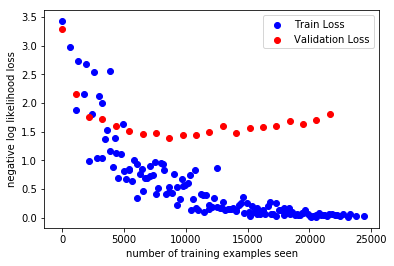

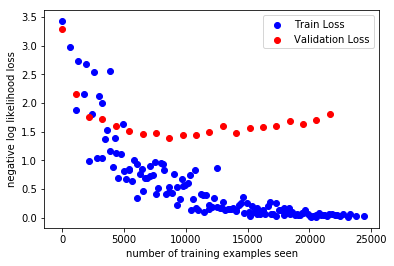

In [0]:
fig = plt.figure()
plt.scatter(my_train_counter, my_train_losses, color='blue')
plt.scatter(my_test_counter, my_test_losses, color='red')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.xlabel('number of training examples seen', color = 'black')
plt.ylabel('negative log likelihood loss', color = 'black')
fig


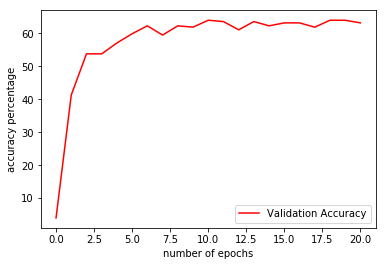

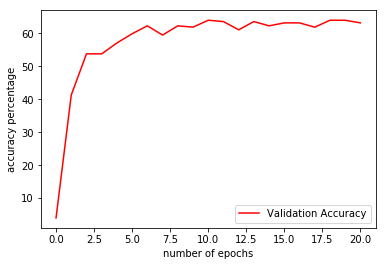

In [0]:
fig = plt.figure()
plt.plot(my_valid_accuracy_x, my_valid_accuracy_y, color='red')
plt.legend(['Validation Accuracy'], loc='lower right')
plt.xlabel('number of epochs', color = 'black')
plt.ylabel('accuracy percentage', color = 'black')
fig